In [69]:
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

data_path = 'ml100/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')

train_Y = np.log1p(df_train['poi'])
ids = df_test['name']

# 考量資料集中非數值特徵，name、email為個人資訊皆Unique data，推測其二與最終分類結果不具相關性，移除此二欄位
# 將最終分類結果 y (poi)移除
train_data = df_train.drop(['name','email_address'] , axis=1)
test_features = df_test.drop(['email_address'] , axis=1)
df_train = df_train.drop(['poi', 'email_address'] , axis=1)
df_test = df_test.drop(['name', 'email_address'] , axis=1)
df = pd.concat([df_train, df_test])
df.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,name,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,RICE KENNETH D,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,SKILLING JEFFREY K,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,SHELBY REX,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,KOPPER MICHAEL J,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,CALGER CHRISTOPHER F,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [70]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_this_person_to_poi,41.095890
from_poi_to_this_person,41.095890
from_messages,41.095890


In [71]:
# 查看資料型態，及缺失值分布狀況
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 32
Data columns (total 20 columns):
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
name                         113 non-null object
other                        93 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with_poi      86 non-null float64
to_messages                  86 non-null float64
total_payment

In [72]:
num_feature = []
for feature in X_df:
    if X_df[feature].dtype == 'float64' :
        num_feature.append(feature)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201BAF0BB08>,
      dtype=object)

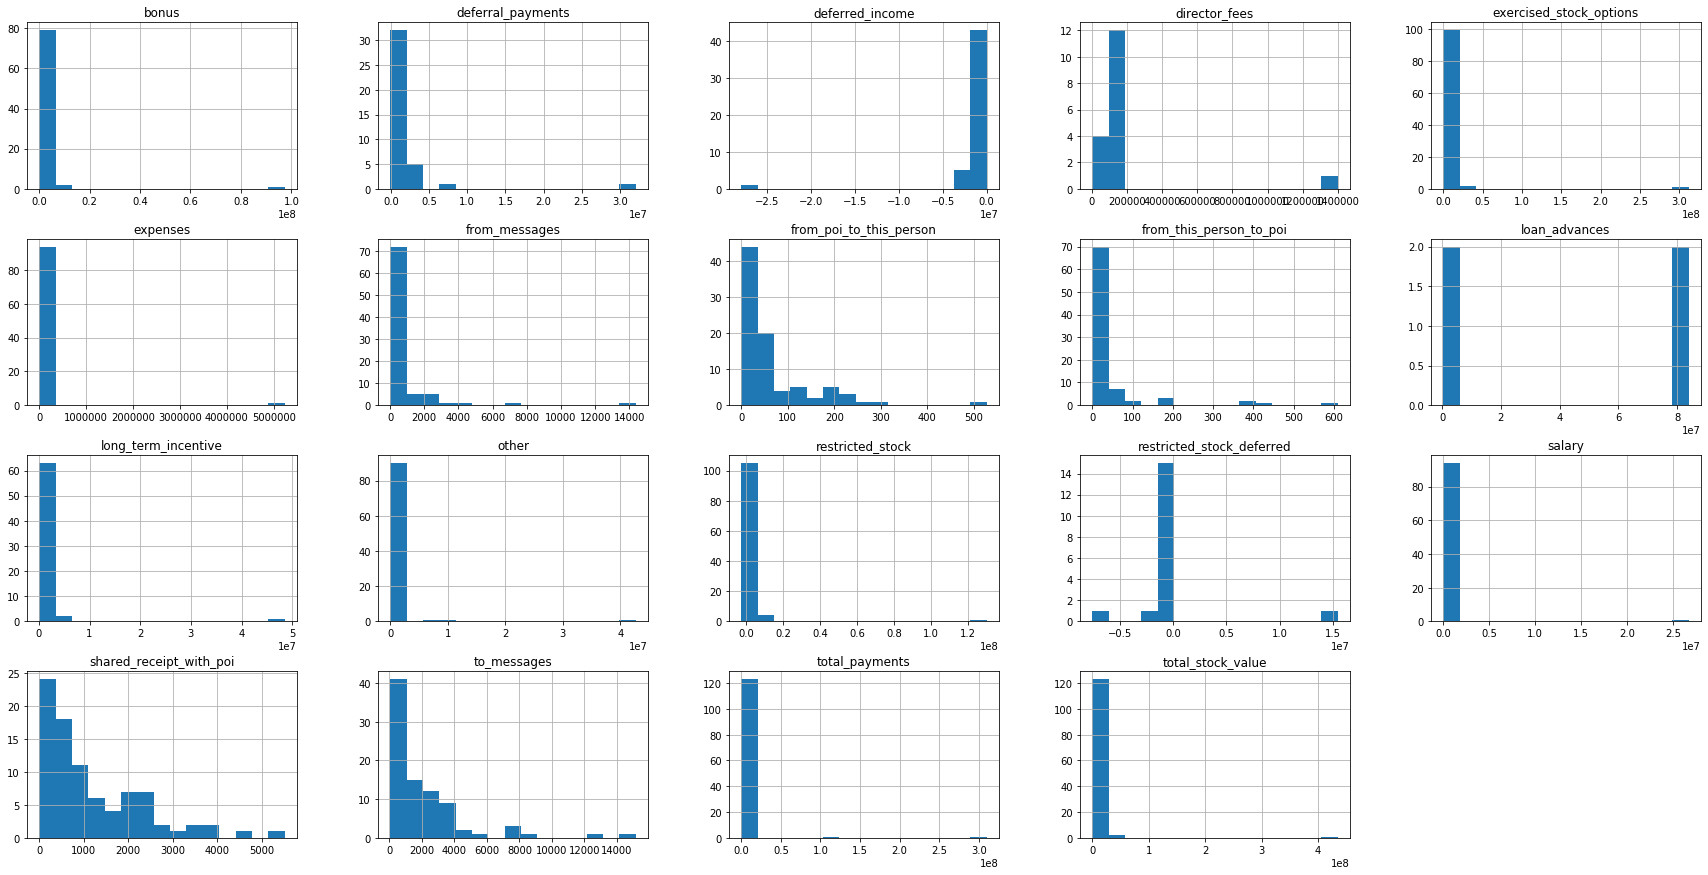

In [73]:
# 各資料欄位視覺化
X_df[num_feature].hist(bins = 15, figsize=(30,15), layout=(4,5))

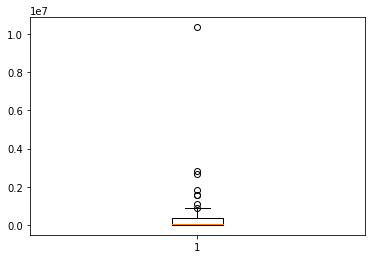

In [74]:
plt.boxplot(df_train['other'].dropna())
plt.show()

In [75]:
nan_median = ['deferral_payments', 'deferred_income', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']
nan_zero = ['bonus', 'director_fees', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'other', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'to_messages']

In [76]:
X_fillna = pd.DataFrame()
for col in nan_median:
    X_fillna[nan_median] = X_df[nan_median].fillna(X_df[nan_median].median())
for col in nan_zero:
    X_fillna[nan_zero] = X_df[nan_zero].fillna(0)

In [77]:
# # 填補空值: 空值數量小於一半之變數，以中位數填補，其餘補0
# c=0
# X_fillna = pd.DataFrame()
# for feature in X_df.columns:
#     if X_df[feature].isna().sum()<len(X_df)/2:
#         X_fillna[feature] = X_df[feature].fillna(X_df[feature].median())
#         c=c+1
#     else:
#         X_fillna[feature] = X_df[feature].fillna(0)
# print('以中位數填補 %s 個feature之空值' % (c))

In [78]:
# Loan_advances及total_payments之特徵分布較分散，新增新feature
X_fillna['loan_advances_label'] = X_df['loan_advances'] > 0
X_fillna['other_label'] = X_df['other'] > 0
X_fillna['expenses_label'] = X_df['expenses'] > 0
X_fillna['total_payments_label'] = X_df['total_payments'].isna()

In [79]:
X_fillna['total_payments'].describe()

count    1.460000e+02
mean     4.509042e+06
std      2.691150e+07
min      1.480000e+02
25%      5.544675e+05
50%      1.101393e+06
75%      1.968287e+06
max      3.098866e+08
Name: total_payments, dtype: float64

In [80]:
# 特徵縮放
for feature in X_fillna:
    if X_fillna[feature].dtype == 'float64' :
        q1 = X_fillna[feature].describe()[4]
        q3 = X_fillna[feature].describe()[6]
        iqr = q3 - q1
        up_bound = q3 + 1.5 * iqr
        low_bound = q1 - 1.5 * iqr
        X_fillna[feature] = X_fillna[feature].clip(low_bound, up_bound)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201C31ED488>,
      dtype=object)

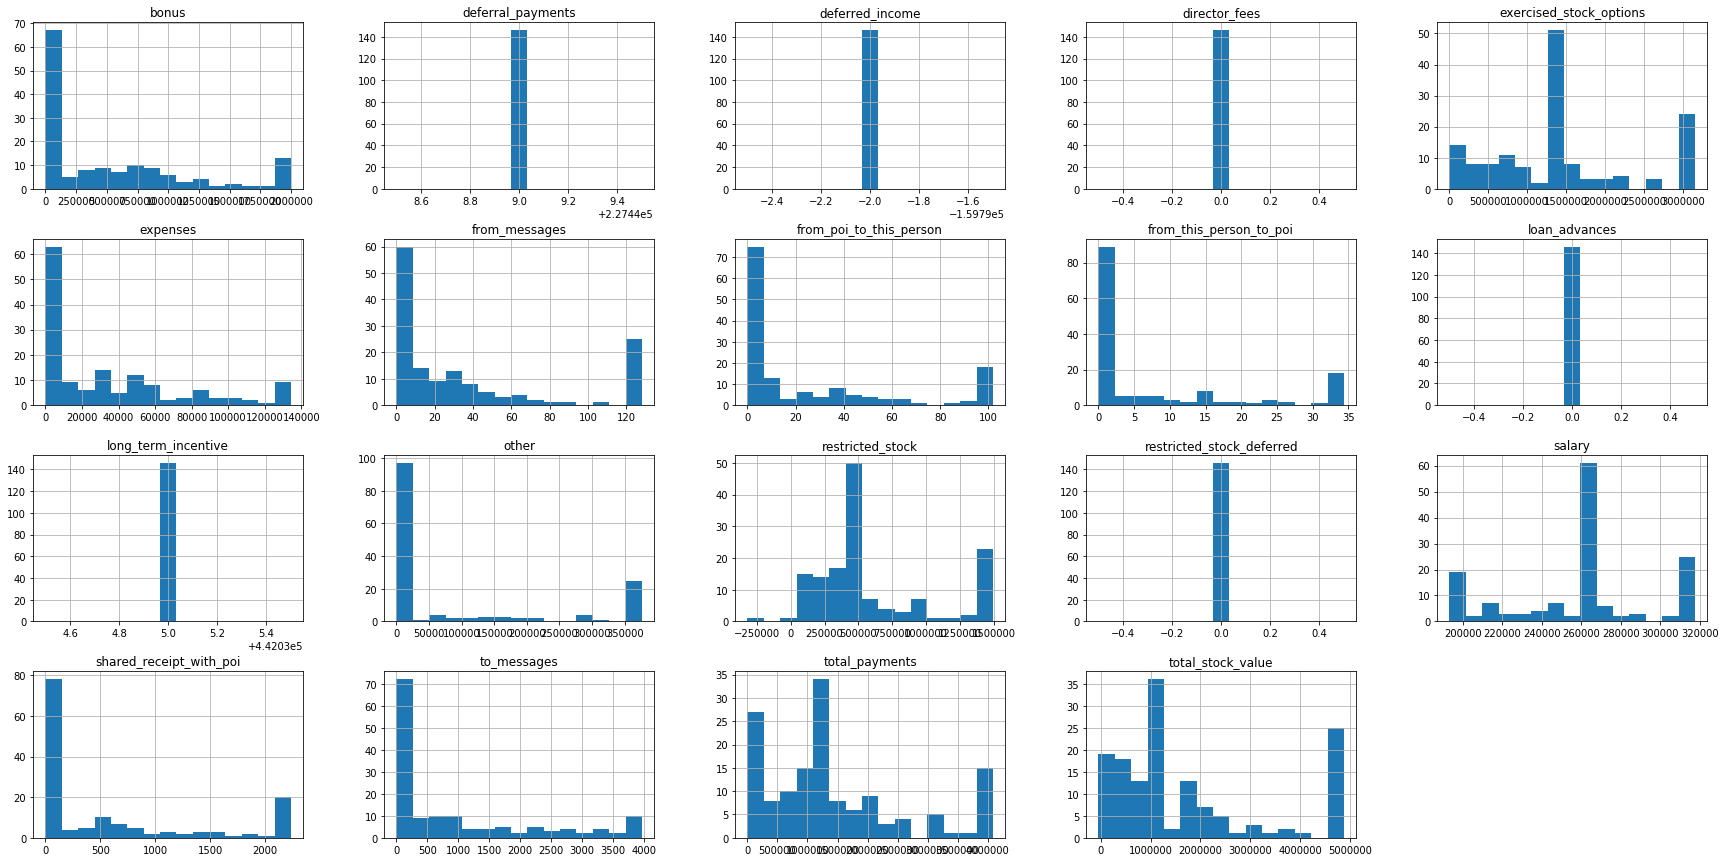

In [81]:
X_fillna[num_feature].hist(bins = 15, figsize=(30,15), layout=(4,5))

In [82]:
X_scaling = StandardScaler().fit_transform(X_fillna)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201C2E16488>,
      dtype=object)

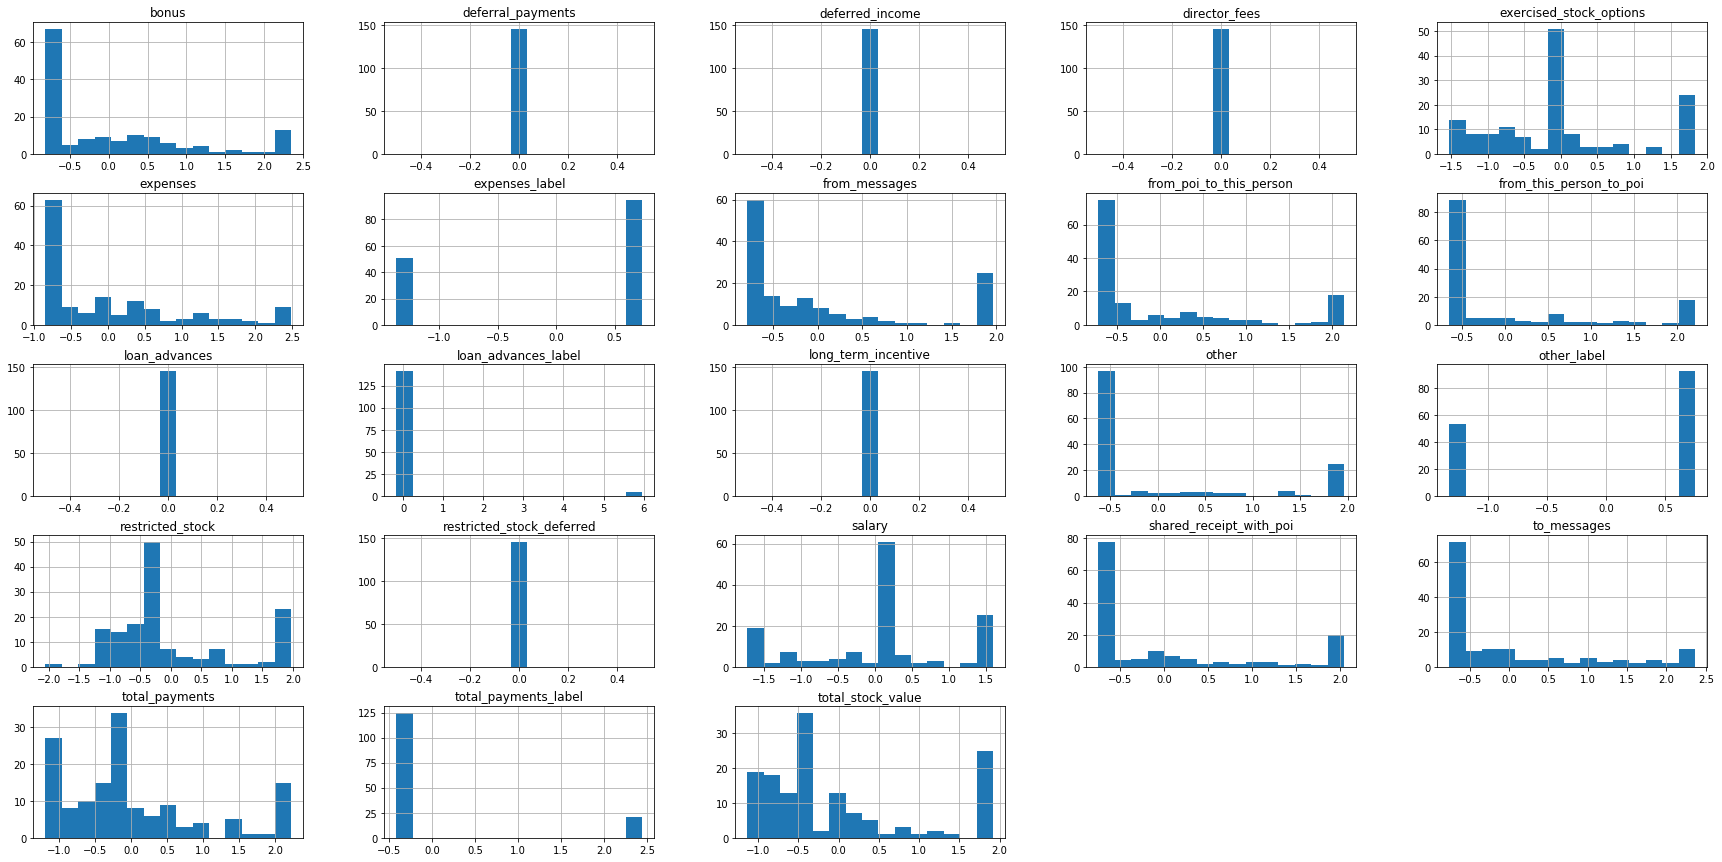

In [83]:
X_scaling = pd.DataFrame(data = X_scaling, columns = X_fillna.columns)
X_scaling.hist(bins = 15, figsize=(30,15), layout=(5,5))

In [84]:
train_num = df_train.shape[0]
X_train = X_scaling[:train_num]
Y_train = train_data['poi']

In [85]:
# 將資料切成training data及testing data
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201C40B7808>,
      dtype=object)

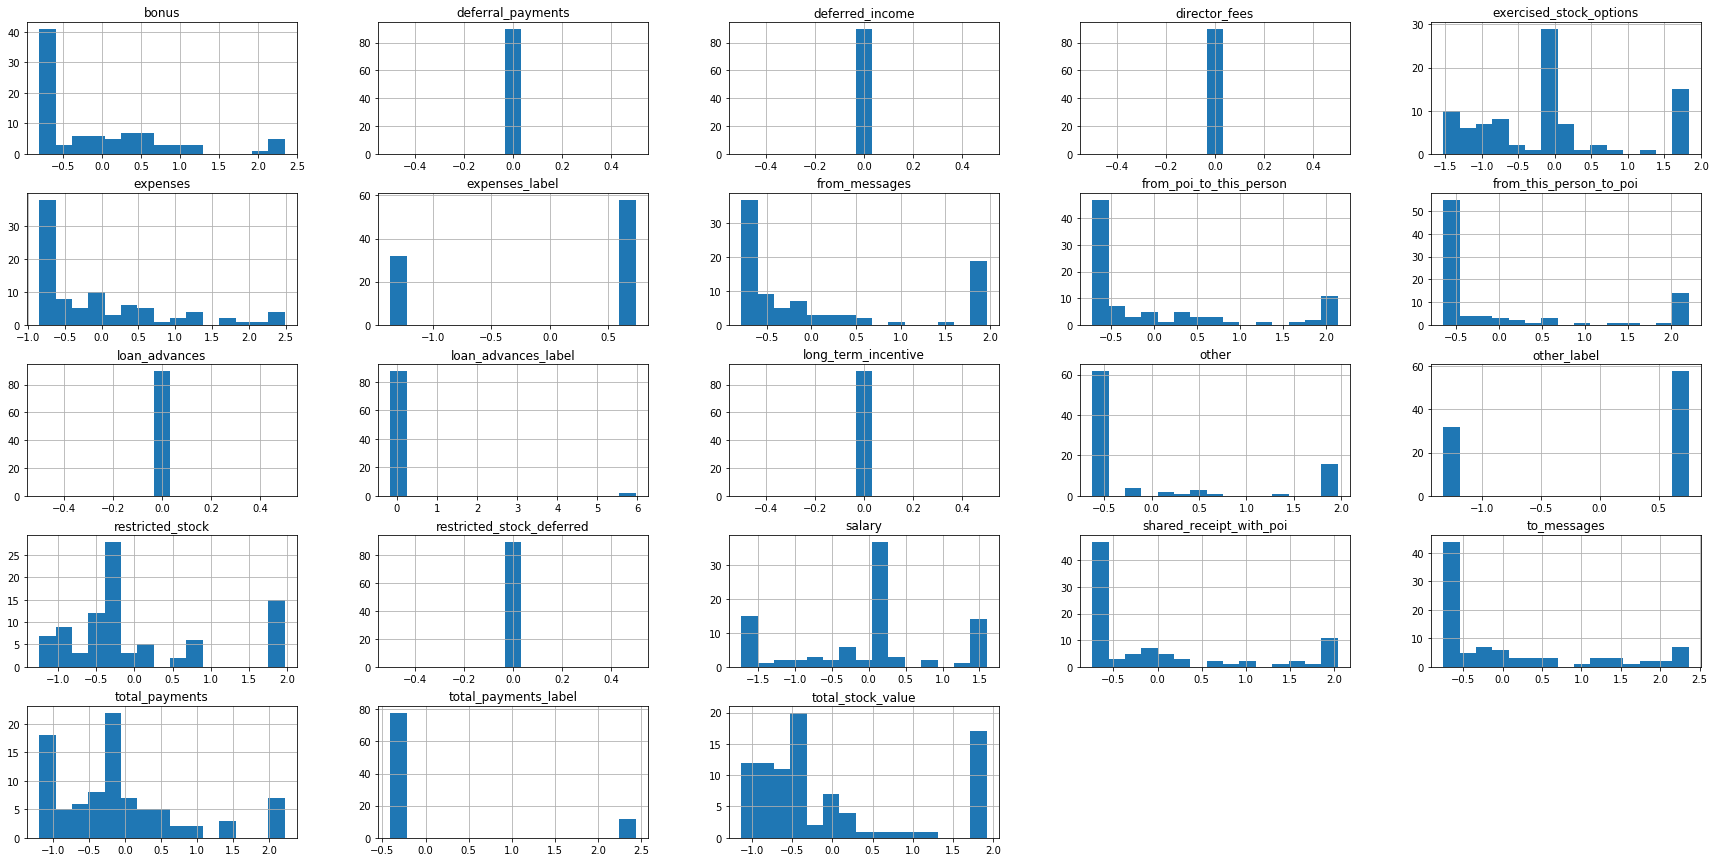

In [86]:
x_train.hist(bins = 15, figsize=(30,15), layout=(5,5))

In [87]:
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=250, max_features=20,
                                  max_depth=6, learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)

In [88]:
X_test = X_scaling[train_num:]
X_test.shape

(33, 23)

In [89]:
# 羅吉斯回歸模型
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
Acc = accuracy_score(lr_pred, y_test)
Acc

0.8260869565217391

In [90]:
lr_sub = lr.predict_proba(X_test)
sub = pd.DataFrame(lr_sub, columns=['0','poi']).iloc[:,1:]
sub['name'] = test_features['name']
sub[['name','poi']].to_csv('lr_submission.csv', index = False)

In [91]:
gdbt.fit(x_train, y_train)
gdbt_pred= gdbt.predict(x_test)
Acc = accuracy_score(gdbt_pred, y_test)
Acc

0.782608695652174

In [92]:
gdbt_sub = gdbt.predict_proba(X_test)
sub = pd.DataFrame(gdbt_sub, columns=['0', 'poi']).iloc[:,1:]
sub['name'] = test_features['name']
sub[['name','poi']].to_csv('gdbt_submission.csv', index = False)

In [93]:
rf.fit(x_train, y_train)
rf_pred= rf.predict(x_test)
Acc = accuracy_score(rf_pred, y_test)
Acc

0.782608695652174

In [94]:
rf_sub = rf.predict_proba(X_test)
sub = pd.DataFrame(rf_sub, columns=['0', 'poi']).iloc[:,1:]
sub['name'] = test_features['name']
sub[['name','poi']].to_csv('rf_submission.csv', index = False)

In [95]:
# 混合泛化預測檔 
blending_sub = lr_sub* 0.3 + gdbt_sub* 0.05+ rf_sub* 0.65
sub = pd.DataFrame(blending_sub, columns=['0', 'poi']).iloc[:,1:]
sub['name'] = test_features['name']
sub[['name','poi']].to_csv('blending_submission.csv', index = False)
# sub = pd.DataFrame({'PassengerId': ids, 'Survived': blending_pred})
# sub['Survived'] =  sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
# sub.to_csv('titanic_blending.csv', index=False)

![Imgur](https://i.imgur.com/gYXagyd.jpg)